In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal
import math
import random
import torch.nn as nn


In [2]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_info = env.action_space
max_action = float(env.action_space.high[0])
print(env.observation_space.shape, obs_dim, action_info, max_action)

(3,) 3 Box(-2.0, 2.0, (1,), float32) 2.0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(in_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU()
        )
        self.mean = nn.Sequential(
            nn.Linear(300, 1)
        )
        self.std = nn.Sequential(
            nn.Linear(300, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        val = self.base(x)
        mean = self.mean(val)
        std = self.std(val)
        return mean, torch.sqrt(torch.exp(std))
    
class VNetwork(nn.Module):
    def __init__(self, in_dim: int):
        """Initialization."""
        super(VNetwork, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(in_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU(),
            nn.Linear(300, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.base(x)

In [9]:
actor = QNetwork(obs_dim).to(device)
critic = VNetwork(obs_dim).to(device)
def select_action(state, is_test = False):
    mean, std = actor(torch.FloatTensor(state).to(device))
    # 得到动作策略的概率质量分布,用该分布初始化采样器
    m = Normal(mean, std)
    # 按该分布做采样,得到一个动作
    action = m.sample()
    # 对概率质量函数取对数,并采样该分布在action的值,即log P在action点的概率密度函数值
    loss = m.log_prob(action)
    return max_action * torch.tanh(action), loss

def critic_value(state):
    return critic(torch.FloatTensor(state).to(device))

In [10]:
gamma = 0.98

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

steps = []
U_s = []
view_losses = []
scores = []
max_epoch = 500
for i in range(max_epoch):
    score = 0
    step = 0
    
    state, _ = env.reset(seed=3)
    trajectories = []
    while True:
        action, log_prob = select_action(state)
        '''从环境中观测到奖励和新的状态'''
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        '''根据策略网络做决策,但不让智能体执行动作'''
        next_action, next_loss = select_action(next_state)
        
        td_target = reward + gamma * critic_value(next_state)
        
        step += 1
        score += reward
        
        trajectories.append([state, action, reward, next_state, next_action, log_prob, done, td_target])
        if done:
            steps.append(step)
            scores.append(score)
            break
        
        state = next_state
        
    # 结束一轮游戏
    U_t = []
    R = 0
    for state, action, reward, next_state, next_action, _, done, _ in trajectories[::-1]:
        R = reward + gamma * R
        U_t.insert(0, R)
        
#         '''让价值网络打分'''
    roll_count = math.floor(len(trajectories) / 8) * 8
    start_idx = 0
    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    G = []
    for k in range(roll_count):
        state, action, reward, next_state, next_action, log_prob, done, td_target = trajectories[start_idx + k]
        log_probs.append(log_prob)
        values.append(td_target)
        rewards.append(reward)
        masks.append(1 - done)
        G.append(U_t[start_idx + k])

    G = torch.FloatTensor(G).to(device)
    values = torch.cat(values)
    advantage = G - values

    actor_loss = 0
    for indx in range(roll_count):
#             actor_loss  = -(log_probs * advantage.detach()).mean()
        actor_loss += -(log_probs[indx] * advantage.detach()[indx])
    actor_loss = actor_loss / roll_count
#     print('actor_loss', actor_loss)
    view_losses.append(actor_loss.item())

    critic_loss = 0.5 * advantage.pow(2).mean()

#     print('critic_loss', critic_loss)
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

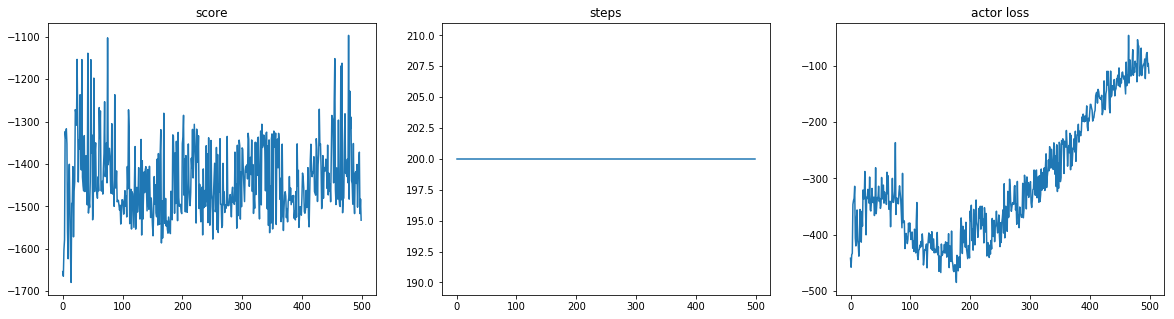

In [11]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
plt.subplot(133)
plt.title('actor loss')
plt.plot(view_losses)
plt.show()

In [12]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=3)
    done = False
    score = 0
    step = 0
    while not done:
        action, _ = select_action(state)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1
        
        if step > 200:
            break

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gymnasium/wrappers/record_video.py:88: UserWarning: WARN: Overwriting existing videos at /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/policy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


Moviepy - Building video /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/policy/rl-video-episode-0.mp4.
Moviepy - Writing video /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/policy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/policy/rl-video-episode-0.mp4
score:  tensor(-1455.0256) step: 201
